### Some good test queries in here, including
- Direct BQ SQL Queries
- Direct Queris of views I saved in BQ

In [80]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import datetime as dt
import matplotlib.dates as mdates
import pandas.io.formats.style

print("System: ", sys.version)
print("Numpy:", np.__version__)
print("Pandas:", pd.__version__)
import geopy.distance 
%matplotlib inline

System:  3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:25:08) 
[GCC 7.5.0]
Numpy: 1.18.5
Pandas: 1.1.1


In [ ]:
%%capture
!pip install google-cloud-bigquery-storage

In [ ]:
import warnings; warnings.simplefilter('ignore')

In [4]:
! bq query --use_legacy_sql=FALSE 'SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_trips` LIMIT 10'

Waiting on bqjob_r6e2d756ce077b63_00000174ce1e0f2c_1 ... (0s) Current status: DONE   
+---------+--------------+---------------------+--------------------+------------------+---------------------+------------------+----------------+-------------+----------+-----------------+
| trip_id | duration_sec |     start_date      | start_station_name | start_station_id |      end_date       | end_station_name | end_station_id | bike_number | zip_code | subscriber_type |
+---------+--------------+---------------------+--------------------+------------------+---------------------+------------------+----------------+-------------+----------+-----------------+
|  944732 |         2618 | 2015-09-24 17:22:00 | Mezes              |               83 | 2015-09-24 18:06:00 | Mezes            |             83 |         653 | 94063    | Customer        |
|  984595 |         5957 | 2015-10-25 18:12:00 | Mezes              |               83 | 2015-10-25 19:51:00 | Mezes            |             83 |        

In [5]:
! bq query --use_legacy_sql=FALSE 'SELECT start_station_name, end_station_name, count(*) as trip_freq FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY start_station_name, end_station_name ORDER BY trip_freq DESC LIMIT 5'

Waiting on bqjob_r37a249d84c9c50ab_00000174ce1e1c10_1 ... (0s) Current status: DONE   
+-----------------------------------------+--------------------------------------+-----------+
|           start_station_name            |           end_station_name           | trip_freq |
+-----------------------------------------+--------------------------------------+-----------+
| Harry Bridges Plaza (Ferry Building)    | Embarcadero at Sansome               |      9150 |
| San Francisco Caltrain 2 (330 Townsend) | Townsend at 7th                      |      8508 |
| 2nd at Townsend                         | Harry Bridges Plaza (Ferry Building) |      7620 |
| Harry Bridges Plaza (Ferry Building)    | 2nd at Townsend                      |      6888 |
| Embarcadero at Sansome                  | Steuart at Market                    |      6874 |
+-----------------------------------------+--------------------------------------+-----------+


In [6]:
# This provides # of trips for morning and afternoon

In [7]:
%%bigquery

SELECT
    Morning,
    Afternoon,
    Total - Morning - Afternoon AS Other,
    Total
FROM
    (
    SELECT
        COUNT(trip_id) as Total,
        COUNT(IF( EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(start_date), HOUR)) BETWEEN 5 AND 11, trip_id, NULL)) AS Morning,
        COUNT(IF( EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(start_date), HOUR)) BETWEEN 12 AND 15, trip_id, NULL)) AS Afternoon
    FROM
    `bigquery-public-data.san_francisco.bikeshare_trips`
    ) AS x;


,Morning,Afternoon,Other,Total
0,404919,176142,402587,983648


#### NOTE TO SELF
SAVING VIEWS IN BQ DIDN'T WORK WHEN I TRIED TO RUN A DISTINCT QUERY INSIDE A LARGER FILE
WHEN I PUT THAT SINGLE QUERY INTO A SEPARATE FILE, IT LET ME SAVE THE VIEW
ALSO NOTE, YOU NEED TO CREATE A DATASET INTO WHICH TO INSERT THE TABLE

### Save trips_by_hour to a dataframe in the first cell
Then print that dataframe out in the next

In [8]:
%%bigquery trips_by_hour

SELECT * 
FROM 
    `zinc-hall-287702.Project_1_W205.trip_per_hour`
LIMIT 1000


In [9]:
trips_by_hour

,Hour,trips
0,0,1696
1,1,797
2,2,420
3,3,427
4,4,1273
5,5,4799
6,6,19830
7,7,65900
8,8,128999
9,9,90264


<BarContainer object of 24 artists>

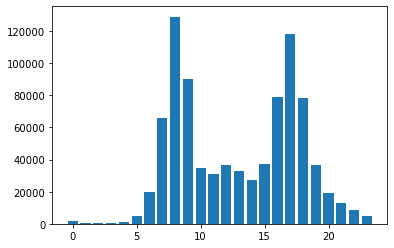

In [10]:
plt.bar(trips_by_hour.Hour, trips_by_hour.trips)

In [11]:
# This pulls the percentiles of ride duration, w/outliers removed

In [12]:
%%bigquery aframe

SELECT approx_quantiles(duration_sec/60, 100) AS percentiles
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE (duration_sec/60 > 2) AND (duration_sec/3600 < 48)


In [13]:
pct_df = pd.DataFrame(aframe["percentiles"][0])

In [14]:
pct_df.head()

,0
0,2.016667
1,2.516667
2,2.833333
3,3.066667
4,3.250000


### WRITEUP STARTS HERE

***
- COUNT OF TOTAL TRIPS PER MONTH, FILTERED FOR OUTLIERS IN RIDE DURATION
- ELIMINATE trips <= 2 MINUTES FROM DATA AS THEY'RE MOST LIKELY MISTAKES
- ELIMINATE trips > 48 HOURS AS THEY ARE EITHER EXTREME OUTLIERS OR ERRORS
- DIDN'T MAKE MUCH OF A DIFFERENCE AS THEY'RE A VANISHINGLY SMALL PCT OF TOTAL
***

In [41]:
%%bigquery monthly_trips

SELECT
    DATE_SUB(DATE_ADD(DATE_TRUNC(DATE(end_date), MONTH),INTERVAL 1 MONTH), INTERVAL 1 DAY) AS Month,
    COUNT(trip_id) AS trips
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE (duration_sec/60 > 2) AND (duration_sec/3600 < 48) 
GROUP BY 1 
ORDER BY 1

In [42]:
# Convert string dates to datetime & subset partial month Aug-13 out of dataset
monthly_trips['Month'] = pd.to_datetime(monthly_trips['Month'])
monthly_trips = monthly_trips[ monthly_trips['Month'] > "2013-08-31" ]
monthly_trips.set_index('Month', inplace = True)

In [17]:
#monthly_trips.drop(columns=['pct_12'], inplace = True)

In [43]:
monthly_trips['rolling_12'] = monthly_trips.trips.rolling(12, min_periods=6).mean()


***
- SUM OF TOTAL TRIP DURATION PER MONTH, MEASURED IN MINUTES
- FILTERED FOR OUTLIERS IN RIDE DURATION
- ELIMINATE trips <= 2 MINUTES FROM DATA AS THEY'RE MOST LIKELY MISTAKES
- ELIMINATE trips > 48 HOURS AS THEY ARE EITHER EXTREME OUTLIERS OR ERRORS
- DIDN'T MAKE MUCH OF A DIFFERENCE AS THEY'RE A VANISHINGLY SMALL PCT OF TOTAL
***

In [44]:
%%bigquery monthly_duration

SELECT
  DATE_SUB(DATE_ADD(DATE_TRUNC(DATE(end_date), MONTH), INTERVAL 1 MONTH), INTERVAL 1 DAY) AS Month,
  SUM(duration_sec)/60 AS duration_minutes
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE (duration_sec/60 > 2) AND (duration_sec/3600 < 48)
GROUP BY 1 
ORDER BY 1

In [45]:
# Convert string dates to datetime & subset partial month Aug-13 out of dataset
monthly_duration['Month'] = pd.to_datetime(monthly_duration['Month'])
monthly_duration = monthly_duration[ monthly_duration['Month'] > "2013-08-31" ]
monthly_duration.set_index('Month', inplace = True)
monthly_duration['rolling_12'] = monthly_duration.duration_minutes.rolling(12, min_periods=6).mean()

***
AGGREGATE TRIPS PER HOUR ON WEEKDAYS TO SEE IF TIME ZONE CODE IS SUSPICIOUS.
IT'S PRETTY CLEAR THE TIME ZONE REPRESENTED AS UTC IS ACTUALLY PST.
AGGREGATE TRIPS PER HOUR SO WE CAN SEE WHERE TRIPS ARE CONCENTRATED AND 
HOPEFULLY IDENTIY COMMUTE HOURS BETWEEN MONDAY & FRIDAY.
***

In [46]:
%%bigquery trips_per_hour

SELECT
  EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(end_date), HOUR)) AS Hour,
  COUNT(DISTINCT trip_id) AS trips, 
FROM
  `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE
  (duration_sec/60 > 2) AND (duration_sec/3600 < 48) AND          
  EXTRACT(DAYOFWEEK FROM end_date) BETWEEN 2 AND 6 
GROUP BY
  1
ORDER BY
  1

In [47]:
trips_per_hour.set_index('Hour', inplace = True)

***
* CREATE A DF W/COMMUTE & TOTAL TRIPS, BY MONTH
* WANT TWO OR THREE COLUMNS
* COMMUTE TRIPS, TOTAL TRIPS
* COMMUTE DEFINITION:
* TRIPS BETWEEN M-F
* TRIPS BETWEEN 7AM-10AM, 4PM-7PM
* IN THE MORNING, ARRIVAL TIMES BASED ON end_date
* IN THE EVENING, DEPARTURE TIME BASED ON start_date
* HOWEVER, GIVEN HOW SHORT MOST RIDES ARE, THE DIFFERENCES ARE LIKELY TO BE IMMATERIAL
***

In [48]:
%%bigquery commute_vs_total_trips

  
SELECT 
    MONTH, COUNT(DISTINCT commuter_trips) as Commuter_Trips, COUNT(DISTINCT total_trips) as Total_Trips
FROM
(
  SELECT
    trip_id AS total_trips,        
    CASE WHEN 
      (duration_sec/60 > 2) AND (duration_sec/3600 < 48) AND  
      ((EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(end_date), HOUR)) BETWEEN 7 AND 9) OR
      (EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(start_date), HOUR)) BETWEEN 16 AND 18)) 

      AND EXTRACT(DAYOFWEEK FROM start_date) BETWEEN 2 AND 6 
      THEN trip_id
      ELSE NULL
      END
      AS commuter_trips,                          
    DATE_SUB(DATE_ADD(DATE_TRUNC(DATE(start_date), MONTH), INTERVAL 1 MONTH), INTERVAL 1 DAY) AS Month
      
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
) 
GROUP BY 1
ORDER BY 1;

***
CREATE TABLE TO LOOK @ MORNING/EVENING BREAKOUT OF COMMUTE TRIPS
***

In [50]:

%%bigquery commute_am_vs_pm


SELECT 
    COUNT(DISTINCT commuter_trips_am), COUNT(DISTINCT commuter_trips_pm), COUNT(DISTINCT commuter_trips_tot)
FROM
(
  SELECT
    trip_id AS total_trips,        
    
    CASE WHEN 
        (duration_sec/60 > 2) AND (duration_sec/3600 < 48) AND  
        (EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(end_date), HOUR)) BETWEEN 7 AND 9) AND
        EXTRACT(DAYOFWEEK FROM end_date) BETWEEN 2 AND 6 
      THEN trip_id
        ELSE NULL
      END
      AS commuter_trips_am,                          
    
    CASE WHEN 
        (duration_sec/60 > 2) AND (duration_sec/3600 < 48) AND  
        (EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(start_date), HOUR)) BETWEEN 16 AND 18)
        AND EXTRACT(DAYOFWEEK FROM start_date) BETWEEN 2 AND 6 
      THEN trip_id
        ELSE NULL
      END
      AS commuter_trips_pm,       

    CASE WHEN 
        (duration_sec/60 > 2) AND (duration_sec/3600 < 48) AND          
        
        ((EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(end_date), HOUR)) BETWEEN 7 AND 9)  OR
        (EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(start_date), HOUR)) BETWEEN 16 AND 18))  
              
        AND EXTRACT(DAYOFWEEK FROM start_date) BETWEEN 2 AND 6 
      THEN trip_id
        ELSE NULL
      END
      AS commuter_trips_tot,      

    DATE_SUB(DATE_ADD(DATE_TRUNC(DATE(start_date), MONTH), INTERVAL 1 MONTH), INTERVAL 1 DAY) AS Month

    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
) 





***
THIS PRODUCES COUNTS OF TRIPS ORGANIZED BY STATIONS PAIR ALONG WITH THEIR LATITUDES AND LONGITUDES
COUNTS FOR A TRIP COUNT TRIP FROM A->B PLUS B->A AS THE SAME TRIP
***

In [109]:
%%bigquery top10_commutes

WITH trip_table AS(
  SELECT
    *,
    CASE WHEN start_station_name < end_station_name THEN start_station_name ELSE end_station_name END AS A,   
    CASE WHEN start_station_name < end_station_name THEN end_station_name ELSE start_station_name END AS B
  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
), 

stations AS(
  SELECT
    name, longitude, latitude
  FROM  
    `bigquery-public-data.san_francisco.bikeshare_stations` 
)  

SELECT
  trip_table.A AS Station_1, trip_table.B AS Station_2, 
  A_station.longitude AS Station_1_longitude,
  A_station.latitude AS Station_1_latitude,
  B_station.longitude AS Station_2_longitude,
  B_station.latitude AS Station_2_latitude,
  COUNT (DISTINCT trip_id) Trip_Count,
  SUM(duration_sec/60)/COUNT(DISTINCT trip_id) AS Avg_Trip_In_Minutes

FROM trip_table    
  LEFT JOIN stations A_station
  ON  trip_table.A = A_station.name 
  LEFT JOIN stations B_station
  ON trip_table.B = B_station.name

WHERE 
  (duration_sec/60 > 2) AND (duration_sec/3600 < 48) AND

  ((EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(end_date), HOUR)) BETWEEN 7 AND 9) OR         
  (EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(start_date), HOUR)) BETWEEN 16 AND 18))

  AND (EXTRACT(DAYOFWEEK FROM start_date) BETWEEN 2 AND 6) 
   
 
GROUP BY 1, 2, 3, 4, 5, 6
ORDER BY 7 DESC
LIMIT 10


In [110]:
# Add temp column to hold distance between stations and then use geopy to populate
t10 = top10_commutes
t10["Distance"] =np.NaN
for index, row in t10.iterrows():  
    t10.Distance[index] = geopy.distance.geodesic((t10.Station_1_latitude[index],t10.Station_1_longitude[index]), 
                                                  (t10.Station_2_latitude[index],t10.Station_2_longitude[index])).miles
    
    

In [111]:
t10

,Station_1,Station_2,Station_1_longitude,Station_1_latitude,Station_2_longitude,Station_2_latitude,Trip_Count,Avg_Trip_In_Minutes,Distance
0,2nd at Townsend,Harry Bridges Plaza (Ferry Building),-122.390288,37.780526,-122.394203,37.795392,10228,9.109805,1.047424
1,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,-122.395470,37.776600,-122.402717,37.771058,9228,4.458162,0.550893
2,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),-122.391034,37.791464,-122.395260,37.776617,8482,10.743612,1.049762
3,Harry Bridges Plaza (Ferry Building),San Francisco Caltrain (Townsend at 4th),-122.394203,37.795392,-122.395260,37.776617,8327,12.420952,1.296157
4,Embarcadero at Sansome,Steuart at Market,-122.403234,37.804770,-122.394434,37.794139,8252,7.658261,0.877208
5,San Francisco Caltrain (Townsend at 4th),Temporary Transbay Terminal (Howard at Beale),-122.395260,37.776617,-122.394643,37.789756,8139,11.060634,0.906793
6,San Francisco Caltrain (Townsend at 4th),Steuart at Market,-122.395260,37.776617,-122.394434,37.794139,8020,12.005981,1.209294
7,2nd at Townsend,Steuart at Market,-122.390288,37.780526,-122.394434,37.794139,7866,8.991626,0.965890
8,2nd at South Park,Market at Sansome,-122.392738,37.782259,-122.400811,37.789625,7086,7.416100,0.673299
9,Market at 10th,San Francisco Caltrain 2 (330 Townsend),-122.417385,37.776619,-122.395470,37.776600,6896,11.176257,1.199665


***
RETRIEVE THE PERCENTILES OF RIDE LENGTHS

<span style="color: red;">DO I NEED TO SUBSET THIS FOR COMMUTER RIDES? PROBABLY</span>
***

In [144]:
%%bigquery ride_length_percentiles

SELECT approx_quantiles(duration_sec/60, 100) AS percentiles
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`

WHERE 
  (duration_sec/60 > 2) AND (duration_sec/3600 < 48) AND

  ((EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(end_date), HOUR)) BETWEEN 7 AND 9) OR         
  (EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(start_date), HOUR)) BETWEEN 16 AND 18))

  AND (EXTRACT(DAYOFWEEK FROM start_date) BETWEEN 2 AND 6) 






In [145]:
ride_length_percentiles = pd.DataFrame(ride_length_percentiles['percentiles'][0])


ride_length_percentiles.rename(columns={0: 'Ride_Length(min)'}, inplace=True)

ride_length_percentiles.index.names = ["Percentile"]


In [137]:
ride_length_percentiles.iloc[50, 0]

8.666666666666666

In [146]:
for pct in range(10,101,10):
    print(pct, ride_length_percentiles.iloc[pct, 0])

10 4.15
20 5.333333333333333
30 6.383333333333334
40 7.416666666666667
50 8.45
60 9.566666666666666
70 10.866666666666667
80 12.516666666666667
90 15.133333333333333
100 2874.2833333333333


In [ ]:
# median ride length for commuters is ~8.5 minutes. For the entire dataset it's ~8.7 minutes. 

***
  
### Project goal: Increase ridership
  
***
To that end, we'll start with two measures of ridership. The first measure is just the number of trips per month.
***
As you can see below, the 12-month moving average, which attempts to adjust for  
significant seasonal variation, declined approximately 11% between Aug-2015 and Aug-2016.  
Additionally, there's little growth to speak of over the entire time frame.

***

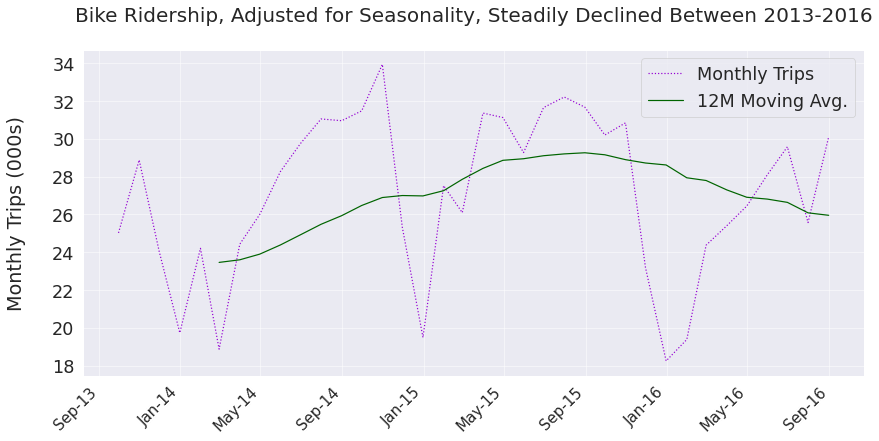

In [55]:

sns.set_context("paper", font_scale = 2, rc={"grid.linewidth": 0.5})
sns.set_style("darkgrid")
fig1, ax1 = plt.subplots(figsize = (14,6))

sns.lineplot(data = monthly_trips.trips/1000, ax = ax1,  color = 'darkviolet', dashes=[':'], label = "Monthly Trips" , legend = False )
sns.lineplot(data = monthly_trips.rolling_12/1000, ax = ax1, color = 'darkgreen',  label = "12M Moving Avg.", legend = False )

ax1.lines[0].set_linestyle(":")

leg = ax1.legend()
ax1.set_ylabel('Monthly Trips (000s)\n')
ax1.set_title("Bike Ridership, Adjusted for Seasonality, Steadily Declined Between 2013-2016\n", size = 20)

fmt = '%b-%y' # Format you want the ticks, e.g. '40%'
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', size = 15)    
ax1.xaxis.set_major_formatter(mdates.DateFormatter(fmt))
leg = ax1.legend()


***
The second measure is the total time spent on bikes. This allows us to 
go a little beyond the number of trips and account for actual usage. 
***

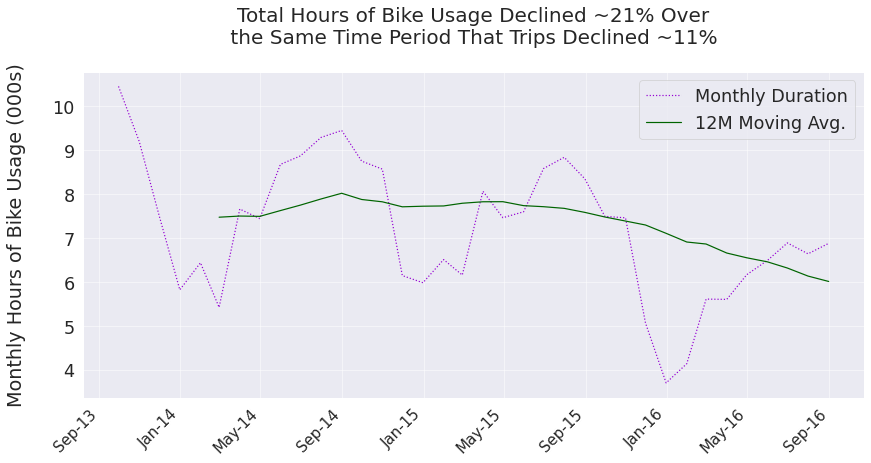

In [56]:

sns.set_context("paper", font_scale = 2, rc={"grid.linewidth": 0.5})
sns.set_style("darkgrid")
fig1, ax1 = plt.subplots(figsize = (14,6))

sns.lineplot(data = monthly_duration.duration_minutes/60000, ax = ax1,  color = 'darkviolet', dashes=[':'], label = "Monthly Duration" , legend = False )
sns.lineplot(data = monthly_duration.rolling_12/60000, ax = ax1, color = 'darkgreen',  label = "12M Moving Avg.", legend = False )

ax1.lines[0].set_linestyle(":")

leg = ax1.legend()
ax1.set_ylabel('Monthly Hours of Bike Usage (000s)\n')
ax1.set_title("Total Hours of Bike Usage Declined ~21% Over\n the Same Time Period That Trips Declined ~11% \n", size = 20)

fmt = '%b-%y' # Format you want the ticks, e.g. '40%'
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', size = 15)    
ax1.xaxis.set_major_formatter(mdates.DateFormatter(fmt))
leg = ax1.legend()


***
As shown above, usage, as measured by hours spent on the bike, shows an even steeper 
decline over the last 12 months than usage as measured by trips
***

***
One of the areas of focus is commute trips. To understand commute trips better, we'd like to see how hourly trips are distributed over weekdays so we can DEFINE what commute hours are.
***

Text(0.5, 0, '\nTime of Day')

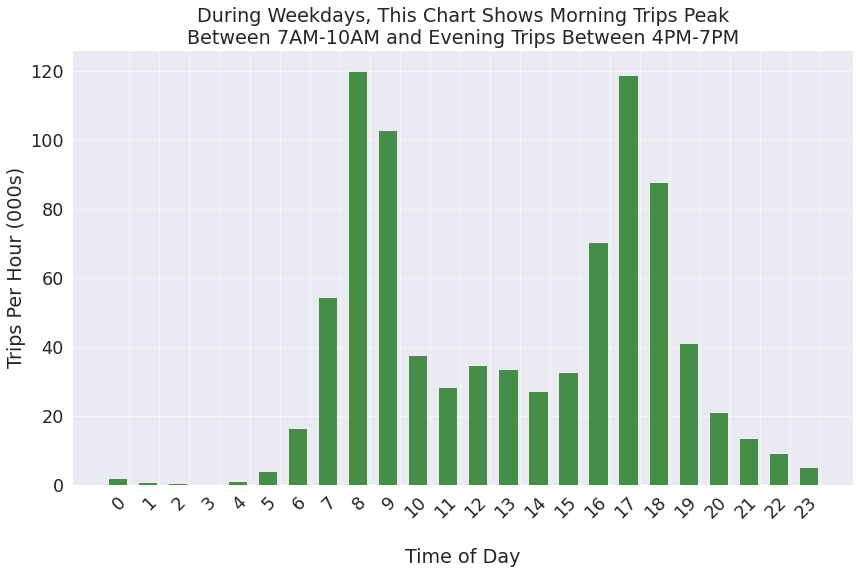

In [57]:

fig, ax = plt.subplots(figsize = (14,8))

# https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

width = 0.8  # the width of the bars

# height of bars
trips = trips_per_hour.trips

# position of bars
br1 = np.arange(len(trips_per_hour.index))

# colors: https://www.colorhexa.com/002fa7
# plot '#1e5dff'


ax.bar(br1, trips/1000, color = [0,.4,0,.7], width = 0.8*width, label="" )


ax.set_xticks([r + width/2 for r in range(len(trips_per_hour))]) 
ax.set_xticklabels(trips_per_hour.index) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right') 


ax.set_title("Trips Each Hour During Weekdays")

ax.set_title("During Weekdays, This Chart Shows Morning Trips Peak\nBetween 7AM-10AM and Evening Trips Between 4PM-7PM")

ax.set_ylabel("Trips Per Hour (000s)")
ax.set_xlabel("\nTime of Day")


***
As the above chart shows, 7AM-10AM & 4PM-7PM between Monday and Friday are when trips peak
We'll use those time periods as part of our definition of commute hours
***

***
It's assumed that commuter trips are important, but we should measure what percentage commuter trips represent of the all trips to see exactly how important they are.
***

In [58]:
# Convert string dates to datetime & subset partial month Aug-13 out of dataset
commute_vs_total_trips['MONTH'] = pd.to_datetime(commute_vs_total_trips['MONTH'])
commute_vs_total_trips = commute_vs_total_trips[ commute_vs_total_trips['MONTH'] > "2013-08-31" ]
commute_vs_total_trips.set_index('MONTH', inplace = True)

# Give the Columns accurate names
#commute_vs_total_trips.rename(columns={"f0_": "Commuter_Trips", "f1_": "Total_Trips"}, inplace=True)



In [60]:
# Convert dataframe into a pivot table so we can get column totals

pivot1 = pd.pivot_table(commute_vs_total_trips, index = 'Year_Ending', values=['Commuter_Trips', 'Total_Trips'], columns = [], aggfunc = np.sum,  margins = True, margins_name='Total')
df2 = pd.DataFrame(pivot1)

# Convert pivot table back into data frame so we can easily add a percent of total column
df2['Percent_of_Total'] = df2.Commuter_Trips/df2.Total_Trips
df2 = df2.style.format({"Commuter_Trips" : "{:,d}", "Total_Trips" : "{:,d}", "Percent_of_Total" : "{:.0%}"       })
df2

,Commuter_Trips,Total_Trips,Percent_of_Total
Year_Ending,,,
2014-08-31,"156,900","313,705",50%
2015-08-31,"202,710","354,152",57%
2016-08-31,"191,167","313,689",61%
Total,"550,777","981,546",56%


***
We can see several things from the table above:
- Commuter trips are a very high percentage of total trips
- Commute hours represent only ~18% of weekly hours, but 61% of trips in the most recent year
- Commute hours as a percentage of total hours increased every year
- There's almost no growth between the first year and the final year of the series

**Conclusion: Commuter trips are, in fact, extremely important to the business**

***

***
The next thing we'll look at is the breakout of the number of commute trips in the morning and the evening
***

In [61]:
# Give the Columns accurate names
commute_am_vs_pm.rename(columns={"f0_": "Morning Commute Trips", "f1_": "Evening Commute Trips", "f2_": "Total Commute Trips"},
                        inplace=True)


In [62]:

index_ = ["Total"]
commute_am_vs_pm.index = index_ 
commute_am_vs_pm = commute_am_vs_pm.style.format({"Morning Commute Trips" : "{:,d}", "Evening Commute Trips" : "{:,d}", 
                                                  "Total Commute Trips" : "{:,d}"})
commute_am_vs_pm

,Morning Commute Trips,Evening Commute Trips,Total Commute Trips
Total,"277,604","273,816","551,255"


***
A quick look shows a very even split between the number of morning and the number of evening commute trips
***

***
##### The next thing we will look at are the 10 frequent commuter routes
##### *Note: These stations pairs are unordered.*
##### *e.g. Both trips from "2nd at Townsend" to "Steuart at Market" and "Steuart at Market" to "2nd at Townsend"*
##### *are treated as a "2nd at Townsend" to "Steuart at Market"*
***


### <span style='color:green'> **Ten Most Frequent Commuter Trips**

In [147]:

#temp_df.style.clear()
temp_df = t10[['Station_1', 'Station_2', 'Trip_Count', 'Avg_Trip_In_Minutes', 'Distance' ]]
#temp_df = temp_df.style.format({"Trips" : "{:,d}"})
temp_df.index = np.arange(1, len(temp_df)+1)
temp_df.index = temp_df.index.rename("Rank") 
temp_df=temp_df.rename(columns={"Distance": "Distance(miles)"})
temp_df=temp_df.style.format({"Trip_Count" : "{:,d}","Avg_Trip_In_Minutes" : "{:,.1f}", "Distance(miles)" : "{:.1f}"      })
temp_df

,Station_1,Station_2,Trip_Count,Avg_Trip_In_Minutes,Distance(miles)
Rank,,,,,
1,2nd at Townsend,Harry Bridges Plaza (Ferry Building),"10,228",9.1,1.0
2,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,"9,228",4.5,0.6
3,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),"8,482",10.7,1.0
4,Harry Bridges Plaza (Ferry Building),San Francisco Caltrain (Townsend at 4th),"8,327",12.4,1.3
5,Embarcadero at Sansome,Steuart at Market,"8,252",7.7,0.9
6,San Francisco Caltrain (Townsend at 4th),Temporary Transbay Terminal (Howard at Beale),"8,139",11.1,0.9
7,San Francisco Caltrain (Townsend at 4th),Steuart at Market,"8,020",12.0,1.2
8,2nd at Townsend,Steuart at Market,"7,866",9.0,1.0
9,2nd at South Park,Market at Sansome,"7,086",7.4,0.7


***
#### <span style='color:green'> *Observations*
##### * Anyone familiar with San Francisco will set that all of these stations are either downtown or in the SOMA neighborhood 
##### * The majority of San Franciscans do not live in either of these neighborhoods
##### * Additionally, all of these stations are either transit hubs for other forms of mass transit or very close to one (e.g. MUNI for
##### bus and light rail within the city, Caltrain and BART for commuters from the South and East Bay as well as ferry service from 
##### the North and East Bay. This likely explains why the same stations appear repeatedly on the list above. 
##### * The distances between these stations are between 0.6 and 1.3 miles, with average trip lengths of between 4.5 and 12.4 minutes.
##### * For commuters, the median trip is ~8.5 minutes while for ALL trips it's ~8.7 minutes. Given that we saw above that commuters
##### represented more than half of all trips, this isn't surprising. 
#### <span style='color:green'> *Conclusions*:
##### * Given that most San Franciscans don't live near these stations and that all of the stations are near mass transit hubs, it 
##### seems likely that the most common commuter use case is to use bikes to go the "final mile" between some other form of mass
##### transit and their home or office. 
##### <span style='color:green'>* While this isn't a definitive picture of ALL commuters, if further analysis shows that this type of commute is representative
##### <span style='color:green'> of the majority of commuters, than that user profile should inform the marketing to those customers. 
***

In [ ]:
# median ride length for commuters is ~8.5 minutes. For the entire dataset it's ~8.7 minutes. 